Models and corresponding seismic
====

In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colorbar as colorbar
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.legend_handler import HandlerBase
from cycler import cycler
from collections import defaultdict
import numpy as np
import pandas as pd
from sbp_modelling.analysis import envelope
from sbp_modelling.multi_source.analysis import mtd, path, load_run as load_run2, top_horizon, base_horizon, lower_top_horizon, lower_base_horizon
from sbp_modelling.multi_source.model import MultiSourceModel, x_0, x_1, v_p_water, v_p_0, v_p_1
from sbp_modelling.multi_source.forward_model import a_x_s, a_z_s, seeds, f_0
from string import ascii_lowercase
import os
from matplotlib.cm import get_cmap

plt.style.use('./mpl/manuscript.mplstyle')
aspect = 1.5
plt.rcParams['figure.figsize'][1] = plt.rcParams['figure.figsize'][0] * aspect

In [2]:
results_path = '../../results/multi-source'

cache = {}

def load_run(*args):
    if args not in cache.keys():
        cache[args] = load_run2(*args, base_path=results_path)
    return cache[args]

model = MultiSourceModel()
params = [(x, 0.05, 3021) for x in (model.no_aniso, 10., 0.1)]

_, mtd_x, mtd_z, __, ___ = model.horizons()

# Check files exist
for a_x in a_x_s:
    for a_z in a_z_s:
        for seed in seeds:
            with open(path(a_x, a_z, seed, results_path), 'rb') as f:
                pass
            
csv_path = '../../results/multi-source/rms-amplitudes.csv'
df = pd.read_csv(csv_path)

In [3]:
twtt, data, sources = load_run(*params[0])

source_ind = (sources[:, 0] >= x_0) & (sources[:, 0] <= x_1)
sources = sources[source_ind]

x_ind = (model.x > x_0) & (model.x < x_1)
z_ind = (model.z > 890) & (model.z < 950)
x = model.x[x_ind]
z = model.z[z_ind]

t_start = 120
t_end = 480
t_ind = (twtt >= t_start) & (twtt <= t_end)
t = twtt[t_ind]

data = data[t_ind][:, source_ind]

x_mtd = 2300
x_outside = 3750

In [4]:
factor = 5e5
def mtd_data(x, a_x, a_z):
    a = np.zeros((len(seeds), len(t)))

    for i, seed in enumerate(seeds):
        twtt, data, _ = load_run(a_x, a_z, seed)
        n = np.argmin(np.abs(sources[:, 0] - x)) # Choose closest source to x
        a[i] = np.interp(t, twtt, data[:, n])

    return envelope(a.T).T * factor

In [5]:
data = []
for i, (a_x, a_z, seed) in enumerate(params):
    twtt, data2, sources = load_run(a_x, a_z, seed)
    data.append(envelope(data2) * factor)

In [6]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        l1 = Line2D([x0, y0 + width], [0.7 * height, 0.7 * height], c='red', lw=0.5)
        l2 = Line2D([x0, y0 + width], [0.3 * height, 0.3 * height], c='blue', lw=0.5)
        return [l1, l2]

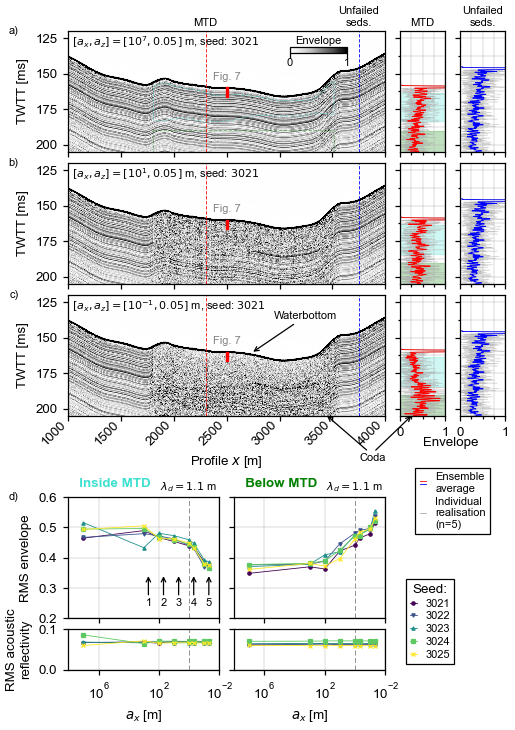

In [7]:
fig = plt.figure(constrained_layout=False)
g = gridspec.GridSpec(7, 4, figure=fig,
                      height_ratios=[3, 3, 3, 0.6, 0.6, 3, 1],
                      width_ratios=[0.5, 0.5, 0.15, 0.15],
                      wspace=0.15,
                      hspace=0.2 / aspect)

sbp = []
trace_1 = []
trace_2 = []

sbp.append(fig.add_subplot(g[0, 0:-2]))
trace_1.append(fig.add_subplot(g[0, -2]))
trace_2.append(fig.add_subplot(g[0, -1], sharey=trace_1[0]))

for i in range(2):
    sbp.append(fig.add_subplot(g[i + 1, 0:-2], sharex=sbp[0]))
    trace_1.append(fig.add_subplot(g[i + 1, -2], sharex=trace_1[0]))
    trace_2.append(fig.add_subplot(g[i + 1, -1], sharex=trace_2[0], sharey=trace_1[i]))
    
    for a in sbp, trace_1, trace_2:
        plt.setp(a[i].get_xticklabels(), visible=False)    

lim = 1.

# Plot analysis zones    

disp_t_max = 205

outline_style = dict(linestyle='--', dashes=(8, 4), lw=0.25)
x = model.x[mtd_x]
y = np.concatenate([top_horizon(x), base_horizon(x)[::-1], top_horizon(x)[0, np.newaxis]])
x = np.concatenate([x, x[::-1], x[0, np.newaxis]])
sbp[0].plot(x, y, color='turquoise', **outline_style)

x = model.x[mtd_x]
y = np.concatenate([lower_top_horizon(x), lower_base_horizon(x)[::-1], lower_top_horizon(x)[0, np.newaxis]])
x = np.concatenate([x, x[::-1], x[0, np.newaxis]])
sbp[0].plot(x, y, color='green', **outline_style)

for i, (a_x, a_z, seed) in enumerate(params):
    last_sbp = sbp[i].imshow(data[i], aspect='auto', interpolation='nearest', cmap='Greys',
                 extent=[sources[0, 0], sources[-1, 0], twtt[-1], twtt[0]], vmin=0, vmax=lim)
    
    sbp[i].set(ylabel='TWTT [ms]', ylim=(disp_t_max, t.min()), xlim=(1000, 4000))        
    
    sf = ticker.ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-5, 5))
    sbp[i].annotate(f'$[a_x, a_z]=[{sf.format_data(a_x)}, {a_z}]$ m, seed: ${seed}$', xy=(sources[0, 0], t.min()), xytext=(2, -2), textcoords='offset points',
                    va='top', ha='left', fontsize='small')

    for ax, xx, cc, label in (trace_1[i], x_mtd, 'red', 'MTD'), (trace_2[i], x_outside, 'blue', 'Unfailed\nseds.'):
        if i == 0:
            ax.annotate(label, xy=(0.5, 1), xytext=(0, 2),
                        xycoords='axes fraction',
                        textcoords='offset points',
                        va='bottom', ha='center', fontsize='small')
            sbp[0].annotate(label, xy=(xx, t.min()), xytext=(0, 2),
                        textcoords='offset points',
                        va='bottom', ha='center', fontsize='small')
        sbp[i].axvline(xx, c=cc, linestyle='-', linewidth=0.5, alpha=1, dashes=(4, 2))
        d = mtd_data(xx, a_x, a_z)
        for trace in d:
            ax.plot(trace, t, c='darkgray', alpha=0.5, linewidth=0.25)
        ax.plot(d.mean(axis=0), t, c=cc, linewidth=0.5)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.grid('on', which='both')
        
        if ax in trace_1:
            ax.axhspan(top_horizon(xx), base_horizon(xx), color='turquoise', alpha=0.25)
            ax.axhspan(lower_top_horizon(xx)[0], lower_base_horizon(xx)[0], color='green', alpha=0.25)
        ax.set(ylim=[t.min(), disp_t_max], xlim=[0, lim])
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.invert_yaxis()

# Axis labels

sbp[-1].set(xlabel='Profile $x$ [m]')
trace_1[2].text(0.5, -0.25, 'Envelope', transform=trace_1[2].transAxes)
plt.setp(sbp[-1].xaxis.get_majorticklabels(), rotation=45, ha="right", va='bottom', rotation_mode="anchor")

# Legend for individual traces

sbp_legend = fig.add_subplot(g[-3, -2:])
sbp_legend.axis('off')

handles = [Line2D([0], [0], color='red', lw=4),]
labels = ['Ensemble average']
sbp_legend.legend(
    [
        object,
        Line2D([0], [0], c='darkgray', lw=0.5)
    ],
    [
        'Ensemble\naverage',
        'Individual\nrealisation\n(n=5)'
    ],
    handler_map={object: AnyObjectHandler()},
    loc='upper center', fontsize='small'
)

# Colorbar for SBP images

cbaxes = inset_axes(sbp[0], width="20%", height="5%", loc='upper right', bbox_to_anchor=(0, 0, 0.9, 0.92),
                    bbox_transform=sbp[0].transAxes)
cbar = fig.colorbar(last_sbp, cax=cbaxes, orientation='horizontal', ticks=(0, lim)) 
cbar.set_label('Envelope', labelpad=-19, fontsize='small')
cbar.ax.tick_params(labelsize='small', pad=0)

# Lower axes for amplitude plots

ax = np.empty((2, 2), dtype='O')

ax[0, 0] = fig.add_subplot(g[-2, 0])
ax[0, 1] = fig.add_subplot(g[-2, 1], sharey=ax[0, 0])
ax[1, 0] = fig.add_subplot(g[-1, 0], sharex=ax[0, 0])
ax[1, 1] = fig.add_subplot(g[-1, 1], sharex=ax[0, 1], sharey=ax[1, 0])

ax_legend = fig.add_subplot(g[-1, -2])
ax_legend.axis('off')

# Dominant wavelength label
wavelength = (v_p_0 + v_p_1) / (2 * f_0)

for a in ax[0, :]:
    plt.setp(a.get_xticklabels(), visible=False)
    a.grid('on')
    a.annotate(f'$\lambda_d={wavelength:.2g}$ m', xy=(wavelength, 1), xytext=(0, 2), textcoords='offset points', ha='center', va='bottom',
             xycoords=transforms.blended_transform_factory(a.transData, a.transAxes), fontsize='small')

for a in ax.ravel():
    a.axvline(wavelength, color='grey', linestyle='dashed', dashes=(6, 3), linewidth=0.5)

for a in ax[:, 1]:
    plt.setp(a.get_yticklabels(), visible=False)
    
for a in ax[1, :]:
    a.set(xlabel='$a_x$ [m]', xscale='log', xlim=[df['a_x'].min(), df['a_x'].max()])
    #a.xaxis.set_major_locator(ticker.LogLocator(base=10,numticks=6))
    a.grid('on')
    a.invert_xaxis()   
    
ax[0, 0].set(ylabel='RMS envelope', yscale='linear', ylim=[0.2, 0.6])
ax[1, 0].set(ylabel='RMS acoustic\nreflectivity', yscale='linear', ylim=[0, 0.1])

for title, c, a in ('   Inside MTD', 'turquoise', ax[0, 0]), ('   Below MTD', 'green', ax[0, 1]):
    a.set_title(title, loc='left', fontweight='bold', c=c)

cmap = get_cmap('viridis')
custom_cycler = (cycler('color', cmap(np.linspace(0, 1, 5))) +
    cycler('marker', ['o', 'v', '^', 's', 'x']))
ax[0, 0].set_prop_cycle(custom_cycler)

finite_iter = iter(custom_cycler)
styles = defaultdict(lambda : next(finite_iter))

for a, field in zip(ax.ravel(), ['rms_amplitude', 'lower_rms', 'rms_reflectivity', 'lower_reflectivity']):
    for a_z in df['a_z'].unique():
        ind = df['a_z'] == a_z
        for seed in df['seed'].unique().astype(int):
            ind2 = df['seed'] == seed
            if field == 'rms_amplitude' or field == 'lower_rms':
                f = factor
            else:
                f = 1
            a.plot(df.loc[ind & ind2]['a_x'], df.loc[ind & ind2][field] * f, label=f'{seed:d}', alpha=1,
                   **styles[seed], markersize=2, linewidth=0.5)

#ax[1, 1].set_xticks(ax[1, 1].get_xticks()[2:-2])
#ax[1, 0].set_xticks(ax[1, 0].get_xticks()[2:-2])
ax[1, 0].set_xlim(10e7, 10e-3)
ax[1, 1].set_xlim(10e7, 10e-3)

handles, labels = ax[0, 0].get_legend_handles_labels()
ax_legend.legend(handles, labels, title='Seed:', loc='lower left', fontsize='small')

def label_axis(axis, i, offset=(-30, 0)):
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset, textcoords='offset points',
                  xycoords='axes fraction', va='center', ha='right', fontsize='small')

sbp[2].annotate('Waterbottom', xy=(2750, 160), xytext=(0.65, 0.8), textcoords=sbp[2].transAxes,
                arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0), fontsize='small')
xy = (0.92, -0.375)
sbp[2].annotate('Coda', xy=(3450, 205), xytext=xy, textcoords=sbp[2].transAxes,
                arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, relpos=(0.4, 1)), fontsize='small')
trace_1[-1].annotate('    ', xy=(0.25, 205), xytext=xy, textcoords=sbp[2].transAxes,
                     arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, relpos=(1, 1)), fontsize='small')

# Fig. 7 cores

for i, a_x in enumerate([500., 50., 5., 0.5, 0.05]):
    ax[0, 0].annotate(f'{i + 1:d}', xy=(a_x, 0.35), xytext=(0, -20), textcoords='offset points',
                      ha='center', arrowprops=dict(arrowstyle='->', shrinkA=0), fontsize='small')

for a in sbp:
    x_core = 2500
    core_length = 2 * 4 / 1.5
    zz = 160.5
    a.plot([x_core, x_core], [zz, zz + core_length], linewidth=2, color='red')
    a.annotate('Fig. 7', xy=(x_core, zz), xytext=(0, 4), textcoords='offset points',
               color='gray', va='bottom', ha='center', fontsize='small')

counter = 0
for axis in sbp + [ax[0, 0]]:
    label_axis(axis, counter)
    counter += 1

In [8]:
fig.savefig('../../manuscript/figures/fig06.pdf')